# Kinetic Coefficients

## Overview

The `polykin.kinetics` module offers a number of classes to deal with the types of kinetic coefficients commonly encountered in polymerization kinetics. 

| Class                       | Required arguments | Optional arguments                    |
|-----------------------------|--------------------|---------------------------------------|
| `Arrhenius`                 | k0, EaR            | T0, Tmin, Tmax, unit, symbol, name    |
| `Eyring`                    | DSa, DHa           | kappa, Tmin, Tmax,  symbol, name      |
| `PropagationHalfLength`     | kp                 | C, ihalf, name                        |
| `TerminationCompositeModel` | k11, icrit         | aS, aL, name                          |

The meanings of all arguments, along with their corresponding units, are documented in the respective docstrings.

## Arrhenius and Eyring

In [1]:
# %pip install polykin
from polykin.kinetics import Arrhenius, Eyring

To instantiate a kinetic coefficient, we call the respective class constructor with the desired argument values. Here are some examples of Arrhenius coefficients.

In [2]:
# Arrhenius coefficient defined by pre-exponential factor (A) and Ea/R.
k1 = Arrhenius(1e10, 2e3)

# Arrhenius coefficient defined by value at reference temperature (T0) and Ea/R.
k2 = Arrhenius(1e5, 3e3, T0=350.)

# Arrhenius coefficient including temperature limits, units, symbol, and name.
k3 = Arrhenius(10**7.63, 32.5e3/8.314,
               Tmin=261., Tmax=366.,
               symbol='k_p', unit='L/mol/s', name='styrene')

k4 = Arrhenius(10**7.22, 17.3e3/8.314,
               Tmin=208., Tmax=343.,
               symbol='k_p', unit='L/mol/s', name='butyl acrylate')

# Array of Arrhenius coefficients.
k5 = Arrhenius([1e3, 2e3], [1.8e3, 4e3], T0=298.,
               Tmin=273., Tmax=373.,
               symbol='k_d', unit='1/min', name='(I1, I2)')

For Eyring coefficients, we proceed similarly, only with different arguments.

In [3]:
# Eyring coefficient defined by entropy and enthalpy of activation.
k6 = Eyring(1e2, 5e4)

# Eyring coefficient including transmission factor, temperature limits, and name.
k7 = Eyring(DSa=20., DHa=1e4, kappa=0.8,
            Tmin=273., Tmax=373.,
            symbol='k_6', name='A->B')

The most important properties of a coefficient can be displayed by evaluating the object directly.

In [4]:
k4

name:            butyl acrylate
symbol:          k_p
unit:            L/mol/s
Trange [K]:      (208.0, 343.0)
k0 [L/mol/s]:    16595869.074375598
EaR [K]:         2080.827519846043
T0 [K]:          inf

or, equivalently, by using the `print()` function.

In [5]:
print(k7)

name:            A->B
symbol:          k_6
unit:            1/s
Trange [K]:      (273.0, 373.0)
DSa [J/(mol·K)]: 20.0
DHa [J/mol]:     10000.0
kappa [—]:       0.8


To evaluate a coefficient at a given temperature, we simply call the object with the temperature value (scalar or array-like) as the first positional argument. The temperature unit can be passed as second argument (default is K). 

In [6]:
# Evaluate k3 at 25°C
k3(25., 'C')

86.28385101961442

In [7]:
# Evaluate k3 at 298.15 K
k3(298.15)

86.28385101961442

In [8]:
# Evaluate k5 at 50°C
k5(50., 'C')

array([1600.15388708, 5684.89928869])

In [9]:
# Evaluate k6 at multiple temperatures (in °C)
k6([25., 50., 75.], 'C')

array([1.80718687e+09, 9.32495924e+09, 3.82259806e+10])

Evaluations outside the specified temperature range are allowed, but raise a warning.

In [10]:
k3(100., 'C')

1203.343508225495

Arrhenius coefficients have the special mathematical property that a product or quotient of two Arrhenius coefficients is also an Arrhenius coefficient. The `Arrhenius` class overloads the `*`, `/` and `**` operators to consider this intrisic feature.

In [11]:
kp1 = Arrhenius(1e3, 2e3, T0=350., symbol='k_{p1}', name='kp1')
Cm1 = Arrhenius(1e-3, 1e3, T0=300., symbol='C_{m1}', name='Cm1')
f = Arrhenius(1., 5e2, T0=320., symbol='f', name='fudge factor')
kfm1 = Cm1*kp1/f
kfm1

name:            Cm1·kp1/fudge factor
symbol:          C_{m1}·k_{p1}/f
unit:            -·-/-
Trange [K]:      (0.0, inf)
k0 [-·-/-]:      1781.336221002905
EaR [K]:         2500.0
T0 [K]:          inf

kfm1 is now a coefficient and can be used as such.

In [12]:
kfm1([25., 50.], 'C')

array([0.40660136, 0.77784632])

### Plots

`Arrhenius` and `Eyring` come with a convenient method called `plot()`, enabling a rapid visualization of the corresponding kinetic coefficients.

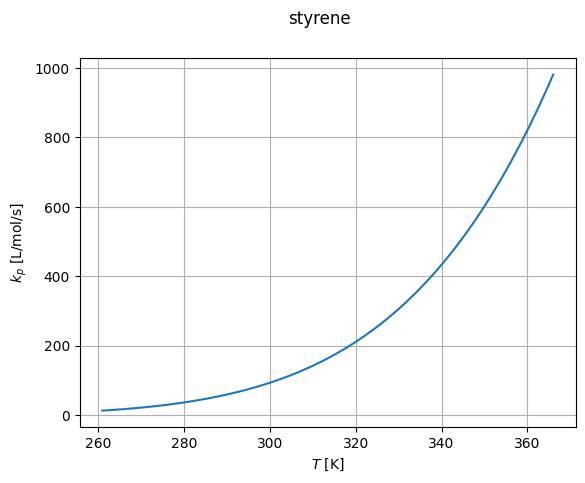

In [13]:
# Default ('linear') plot over the validity range 
k3.plot(Tunit='K')

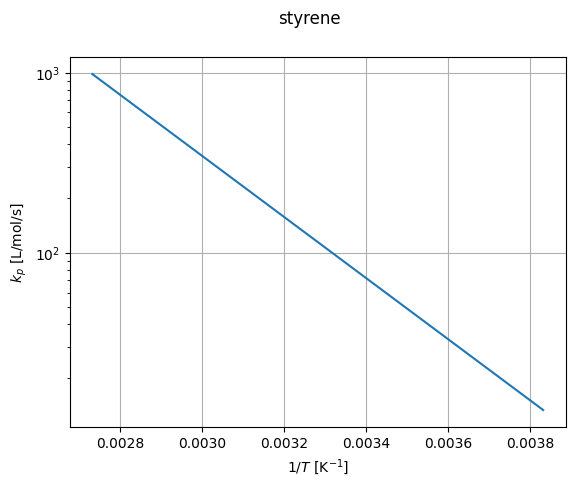

In [14]:
# Arrhenius plot over the validity range 
k3.plot(kind='Arrhenius')

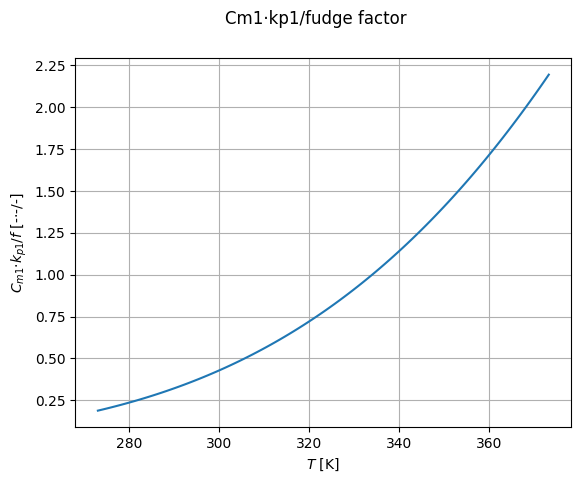

In [15]:
# If no temperature range is known, the plot range defaults to 0-100°C
kfm1.plot()

Lastly, the function `plotequations()` can be used to overlay multiple coefficients on the same plot. The optional keywords arguments are those of the `plot()` method. 

In [16]:
from polykin import plotequations

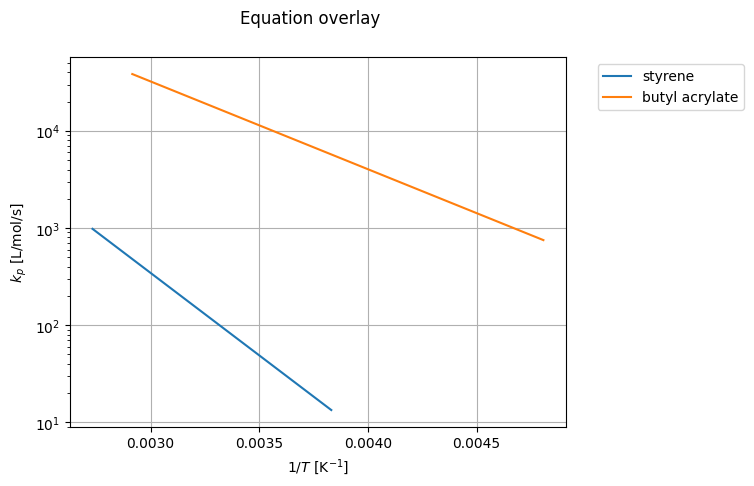

In [17]:

_ = plotequations([k3, k4], kind='Arrhenius')

## Chain-length dependent coefficients

### PropagationHalfLength 

In [18]:
from polykin.kinetics import PropagationHalfLength

This class implements the chain-length-dependent $k_p$ equation proposed by [Smith et al. (2005)](https://doi.org/10.1016/j.eurpolymj.2004.09.002). The class only describes the chain-length effect; the temperature effect must be described separtely (e.g., by `Arrhenius` or `Eyring`). 

In [19]:
# CLD-kp
kpi = PropagationHalfLength(kp=k3, C=10, ihalf=0.5, name='kp(T,i) of styrene')

In [20]:
# kp at 50°C for a trimeric radical
kpi(50, 3, Tunit='C')

371.75986615653215

In [21]:
# kp at 50°C for a series of oligomer lengths
kpi(50, [1, 2, 3, 10], Tunit='C')

array([2379.2631434 ,  773.26052161,  371.75986616,  237.93448289])

### TerminationCompositeModel

In [22]:
from polykin.kinetics import TerminationCompositeModel

This class implements the chain-length-dependent composite termination model proposed by [Smith & Russel (2003)](https://doi.org/10.1002/mats.200390029). The class only describes the chain-length effect; the temperature effect must be described separtely (e.g., by `Arrhenius` or `Eyring`). 

In [23]:
# kt(T) of monomeric radicals
kt11 = Arrhenius(1e9, 2e3, T0=298., symbol='k_t(T,1,1)', unit='L/mol/s',
                 name='kt11 of Y')

# CLD-kt
ktij = TerminationCompositeModel(kt11, icrit=30, name='ktij of Y')

In [24]:
# kt at 25°C between radicals with chain lengths 150 and 200
ktij(25., 150, 200, Tunit='C')

129008375.03821689

The internal functions are vectorized, so the arguments can also be arrays. For example, we can create a contour plot of $k_t(i,j)$ with just a few lines of code.

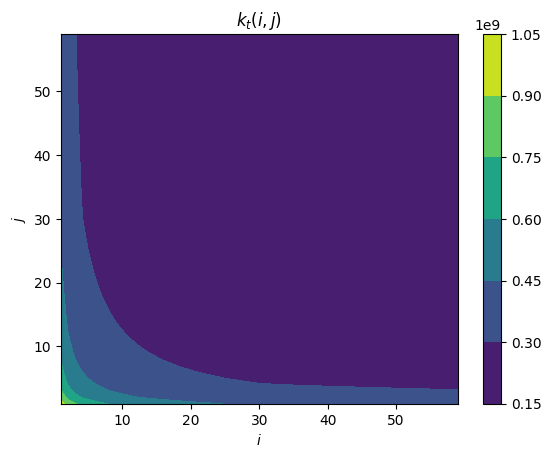

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Generate mesh of chain-lengths
length_range = np.arange(1, 60)
mesh = np.meshgrid(length_range, length_range)

# Evaluate kt for mesh
kt_result = ktij(T=25., i=mesh[0], j=mesh[1], Tunit='C')

# Plot
plt.contourf(length_range, length_range, kt_result)
plt.colorbar()
plt.xlabel(r"$i$")
plt.ylabel(r"$j$")
_ = plt.title(r"$k_t(i,j)$")